# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

***Описание данных***

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


**План работы**:

В текущей формулировке задачи можно наметить два пути решения:

- **Первый путь**:
  - Строим большую выборку оценок на основе оценок комьюнити и экспертов, векторизуем описания и изображения, конкатенируем пары векторов и это становится нашим признаком, а ему в соответствие ставится сводная оценка. 
  - На этих данных обучаем модель. 
  - Минусы: в дальнейшем, для того, чтобы определить, какое изображение лучше подходит к запросу, через модель придётся прогнать вектора ВСЕХ имеющихся изображений (модель на вход требует описание+изображение)

- **Второй путь**:
  - Строим преобразование вектора описания в вектор изображения (в простейшем случае линейное на линейной регрессии). В этом случае экспертные оценки нам нужны только для того, чтобы отбросить недостоверные пары описание - фото. 
  - После обучения модели нам останется только подать на вход вектор запроса и получить вектор изображения.
  - Далее находим в базе вектора, максимально близкие к полученному. Это и будут искомые изображения. 
  - Минусы: не понятны критерии качества обучения. В процессе обучения мы получим вектор "изображения" и можем сравнить его с вектором правильного изображения, получим между ними некоторое расстояние. Пока не понятно как понять, что расстояние достаточно мало или недопустимо велико и какие использовать метрики.

In [1]:
import pickle
import re
from collections import Counter
from os.path import exists, isfile, join

import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from ipywidgets import IntProgress
from matplotlib import pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm, trange

In [3]:
train_path = join(data_path, 'train_images')
test_path = join(data_path, 'test_images')

In [4]:
df_train = pd.read_csv(join(data_path, 'train_dataset.csv'))

In [5]:
df_train.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [6]:
df_train.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Как видно из таблицы, в тренировочном датасете у нас 1000 изображений, имеющих 5822 связей с описаниями, 977 из которых уникальны.

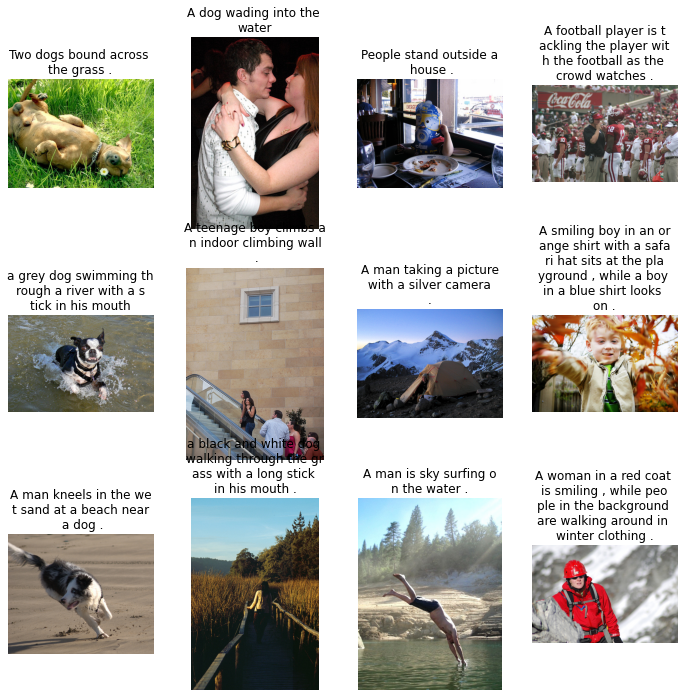

In [7]:
rows = 3
columns = 4

fig = plt.figure(figsize=(12, 12))
count = 1
for _, file, _, query_text in df_train.sample(rows * columns).itertuples():
    img = Image.open(join(train_path, file))
    fig.add_subplot(rows, columns, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis('off')
    chunks, chunk_size = len(query_text), 22
    plt.title(
        '\n'.join(
            [query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]))

Для удобства дальнейшей работы переименуем столбец query_id в annotation_id:

In [8]:
df_train = df_train.rename(columns={'query_id': 'annotation_id'})

Посмотрим экспертные оценки точности анотирования фото:

In [9]:
expert_annotations = pd.read_csv(
    join(data_path, 'ExpertAnnotations.tsv'), sep='\t', header=None)

In [10]:
expert_annotations.columns = ['image', 'annotation_id', 'score_1', 'score_2', 'score_3']

In [11]:
expert_annotations.head()

,image,annotation_id,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [12]:
expert_annotations.describe()

,score_1,score_2,score_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Видно, что эксперты не высокого мнения о качестве разметки: 
- медиана у двух экспертов из 3 равна 1, т.е. эксперты считают, что 50% изображений и их описаний совершенно не соответствуют друг другу
- лишь один эксперт считает, что в 50% случаев запрос содержит элементы описания изображения, но в целом фото тексту не соответствует

Посмотрим данные по соответствию изображения и описания, полученные с помощью краудсорсинга:

In [13]:
crowd_annotations = pd.read_csv(
    join(data_path, 'CrowdAnnotations.tsv'), sep='\t', header=None)

In [14]:
crowd_annotations.columns = ['image', 'crowd_id', 'ratio_ppl_plus', 'count_ppl_plus', 'count_ppl_minus']

In [15]:
crowd_annotations.head()

,image,crowd_id,ratio_ppl_plus,count_ppl_plus,count_ppl_minus
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Теперь посмотрим на тестовые данные:

In [16]:
test_queries = pd.read_csv('to_upload/test_queries.csv', sep='|', index_col=0)

In [17]:
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [18]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


- В тестовой выборке 100 фото, которым соответсвует 500 уникальных описаний
- Получается, что каждой фотографии соответствует в точности 5 уникальных описаний.

In [19]:
test_images = pd.read_csv('to_upload/test_images.csv')

In [20]:
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [21]:
test_images.describe()

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


### Вывод

Были загружены:

- тренировочный датасет из 5822 пар изображение-описание
- набор оценок экспертов, которые определяли соответствие описания изображдению, это те же 5822 записи фото-описание
- набор тестовых запросов и изображений, на которых предстоит проверить качество работы обученных моделей.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Как очевидно из задания, поставленная задача распадается на две:

- нужно на основе описаний в тренировочном датасете и оценок экспертов выявить неприемлемый контент и удалить его из обучающей выборки;
- нужно убрать пары описание-фото, которые не соответствуют друг другу, чтобы не обучать модель на заведоми неправильных сочетаниях

На оставшейся выборке обучить модель, которая будет сопоставлять изображения заданным описаниям

### Построение сводной экспертной оценки

Эксперта три, но оценка нужна одна, поэтому используем метод голосования: 
- если 2 эксперта поставили одинаковую оценку, она считается верной
- если все три оценки разные, такое описание отбрасывается

Построим функцию, которая принимает тройку оценок и возвращает ту, что совпадает хотя бы у двоих. 

Иначе возвращает "None":

In [22]:
def voting(v1, v2, v3):
    if v1 == v2 or v1 == v3:
        return v1
    elif v2 == v3:
        return v2
    else:
        return None

In [23]:
expert_annotations['experts'] = expert_annotations.apply(
    lambda x: voting(x['score_1'], x['score_2'], x['score_3']), axis=1)

Удаляем несогласованные оценки:

In [24]:
expert_annotations = expert_annotations.dropna(subset=['experts'])

In [25]:
expert_annotations.head()

,image,annotation_id,score_1,score_2,score_3,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


Масштабируем сводную оценку:

In [26]:
mm_scaler = MinMaxScaler()

In [27]:
expert_annotations["experts"] = mm_scaler.fit_transform(expert_annotations[["experts"]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Нас интересуют только более-менее соответствующие друг другу изображения и описания, поэтому отбросим сочетания, для которым экспертная оценка ниже 0,5:

In [28]:
expert_annotations = expert_annotations.drop(
    expert_annotations[expert_annotations["experts"] < 0.5].index, axis=0)

In [29]:
expert_annotations.shape

(803, 6)

Получается, правильных описаний к фото у нас всего 803. Очень мало. Попробуем снизить планку точности оценок, но это чревато ошибками сопоставления.

Наложим полученные экспертные оценки на тренировочный датасет:

In [30]:
df_train = (df_train.set_index(['image', 'annotation_id'])
    .join(expert_annotations.set_index(['image', 'annotation_id'])[['experts']],
        how='inner',).reset_index())

### Лемматизация описаний

Лемматизируем описания фотографий, применим к леммам векторайзер:

In [31]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [33]:
lemmatizer = WordNetLemmatizer()

Для дальнейшей работы тексты нужно лемматизировать и токенизировать. Иногда для правильной лемматизации лемматезатору требуется уточнение, какой частью речи является слова. Эту информацию также можно получить средствами nltk:

Если слово не является существительным, прилагательным, гаголом или наречием, назначаем его существительным:

In [34]:
def pos_tag(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [35]:
%%time
df_train['lemm_query'] = df_train['query_text'].apply(
    lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]))

CPU times: user 2.26 s, sys: 140 ms, total: 2.4 s
Wall time: 2.39 s


In [36]:
df_train['lemm_query'] = df_train['lemm_query'].apply(
    lambda x: (' '.join(re.sub(r'[^a-zA-Z ]', ' ', x).split()).lower()))

#### Удаление проблемного контента

- cоставим список слов, используемых в английском для обозначения детей и подростков
- напишем функцию, которая будет искать эти слова в лемматезированных текстах

In [37]:
child_stop = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "teeny",
    "juvenile",
    "teener",
    "stripling"]

- Последовательно ищем слова из стоп-листа child_stop в заданном тексте text.
- Возвращаем True, если нашлось хотя бы одно слово

In [38]:
def chld_text(text: str) -> bool:
    res = False
    for w in child_stop:
        res |= text.lower().find(w) > -1
    return res

In [39]:
df_train['child'] = df_train.apply(
    lambda x: chld_text(x['lemm_query']), axis=1)

Удаляем найденные изображения с детьми:
- составляем список изображений, где обнаружены дети
- удаляем все записи, содержащие эти изображения

In [40]:
child_images = set(df_train[df_train['child'] == True]['image'])

In [41]:
df_train = df_train.drop(
    df_train[df_train['image'].isin(child_images)].index, axis=0)

In [42]:
df_train.shape

(646, 6)

Осталось всего 646 описания

#### Разбиение тренировочного множества на тренировочную и валидационную выборки

Прежде чем векторизовать набор описаний, отделим валидационную выборку: её не следует использовать при эмбеддинге.

Т.к у нас одному изображению соответствует несколько описаний, то случайное разделение может привести к тому, что одно и тоже фото может оказаться и в тестовой и валидационой, что недопустимо

In [43]:
df_train.head()

,image,annotation_id,query_text,experts,lemm_query,child
5,1425069308_488e5fcf9d.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,1.000000,a white dog jump to catch a blue ball in a liv...,False
8,1897025969_0c41688fa6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
9,2340206885_58754a799a.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
10,317383917_d8bfa350b6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
11,3223224391_be50bf4f43.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False


In [44]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)
train_indices, test_indices = next(
    gss.split(
        X=df_train.drop(columns=['annotation_id']),
        y=df_train['annotation_id'],
        groups=df_train['image']))
train_df, valid_df = df_train.iloc[train_indices], df_train.iloc[test_indices]

In [45]:
train_df.head()

,image,annotation_id,query_text,experts,lemm_query,child
5,1425069308_488e5fcf9d.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,1.000000,a white dog jump to catch a blue ball in a liv...,False
8,1897025969_0c41688fa6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
9,2340206885_58754a799a.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
10,317383917_d8bfa350b6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
12,2207244634_1db1a1890b.jpg,3119076670_64b5340530.jpg#2,Snowboarder in the air performing a stunt .,0.666667,snowboarder in the air perform a stunt,False


## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

Опыт спринта, посвящённого обработке естественных языков, говорит, что TF-IDF и word2vec справляются примерно одинаково с некоторым перевесом в пользу TF-IDF. BERT, может и хороша, но без мощной видекарты там нечего ловить. Используем для векторизации модель TF-IDF. Для эмбеддинга будем использовать train_df

In [46]:
tfvect_short = TfidfVectorizer(stop_words=stop_words)

In [47]:
tf_matrix_short = tfvect_short.fit_transform(train_df['lemm_query'])

In [48]:
tf_matrix_short.todense().shape

(493, 432)

In [49]:
tfvect = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2))

In [50]:
tf_matrix = tfvect.fit_transform(train_df['lemm_query'])

In [51]:
tf_matrix.todense().shape

(493, 1338)

Использование даже двусловных н-грамм приводит к увеличению размерности вектора в 3 с лишним раза. С одной стороны, размер нашего датасета весьма скромен и его может не хватить на обучение модели большой размерности. С другой опыт использования эмбеддингов текстов говорит о том, что н-граммы положительно влияют на качество сопоставления текстов

In [52]:
train_df['query_vector'] = tf_matrix.todense().tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
train_df['query_vector'] = train_df['query_vector'].apply(
    lambda x: tf.convert_to_tensor([x], dtype=np.float64))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Теперь на основе обученной модели векторизуем валидационные описания:

In [54]:
tf_matrix = tfvect.transform(valid_df['lemm_query'])
valid_df['query_vector'] = tf_matrix.todense().tolist()
valid_df['query_vector'] = valid_df['query_vector'].apply(
    lambda x: tf.convert_to_tensor([x], dtype=np.float64))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Зафиксируем величину векторов описаний

In [55]:
text_vector_size = train_df.loc[df_train.index[0], 'query_vector'].shape[1]

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Задача векторизации изображений с помощью свёрточной нейросети достаточно проста: 
1. Приводим изображения к формату, на котором обучена наша нейросет. Будем использовать ResNet50, обученную на ImageNet, так что нужно привести изображения к формату (224, 224, 3)
2. На выходе ResNet ставим полносвязный слой, колочество нейронов в котором и определит размерность нашего вектора изображений

Размерность вектора изображения задаём равной размерности векторов описаний.

In [56]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    cnn = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    model = Sequential()
    model.add(cnn)
    model.add(GlobalAveragePooling2D())
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

    return model

In [57]:
def image_to_array(file: str, path: str = train_path, wh: int = 224, ht: int = 224):
    img = image.load_img(join(path, file), target_size=(wh, ht))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [58]:
model = create_model((224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [59]:
image_vec = pd.DataFrame(
    index=df_train['image'].unique(), columns=['image_vector']).reset_index()

In [60]:
image_vec.columns = ['image', 'image_vector']

In [61]:
%%time
image_vec['image_vector'] = image_vec.apply(
    lambda x: tf.cast(model(image_to_array(x['image'])), dtype=np.float64), axis=1)

CPU times: user 25.4 s, sys: 812 ms, total: 26.3 s
Wall time: 32 s


In [62]:
image_vector_size = image_vec.loc[0, 'image_vector'].shape[1]
image_vector_size

2048

In [63]:
train_df = train_df.merge(image_vec, on='image', how='left')
valid_df = valid_df.merge(image_vec, on='image', how='left')

Теперь в нашем тренировочном датасете имеются векторы описаний и фотографий в едином формате np.array. Можно строить модель для сопоставления векторов между собой.

### Вывод

1. Была построена единая экспертная оценка. Отброшены описания, недостоверные с точки зрения экспертов.
1. Удалено около 500 изображений, в описаниях которых упоминались дети и подростки.
1. С помощью TF-IDF были векторизованы описания изображений в тренировочном датасете. Размерность полученных векторов - 1528.
1. С помощью предобученной свёрточной нейросети ResNet50 были векторизованы изображения. Размерность полученных векторов совпадает с размерностью векторов описаний.

## Обучение модели предсказания соответствия

Пришло время обучить модели, которые бы ставили в соответствие "близким" описаниям "близкие" фото. В качестве моделей исполльзуем линейную регрессию и нейросеть.

Начнём с логистической регрессии

In [64]:
X_train = train_df[['annotation_id', 'query_vector']]
y_train = train_df[['image', 'image_vector']]

In [65]:
X_valid = valid_df[['annotation_id', 'query_vector']]
y_valid = valid_df[['image', 'image_vector']]

### Линейная регрессия

Обучим линейную регрессию средствами библиотеки Tensorflow:
- создадим рандомные значения для вектора весов W и смещения b

In [66]:
X = tf.stack(X_train['query_vector'])
Y = tf.stack(y_train['image_vector'])

Трёхмерный тензор входных векторов нам ещё пригодится, а вот вектора изображений лучше оставить в виде pd.Series

In [67]:
X_val = tf.stack(X_valid['query_vector'])

In [68]:
X.shape, Y.shape

(TensorShape([493, 1, 1338]), TensorShape([493, 1, 2048]))

In [69]:
W = tf.Variable(np.random.randn(text_vector_size, image_vector_size), name='W')
b = tf.Variable(np.random.randn(1, image_vector_size), name='b')

In [70]:
W.shape, b.shape

(TensorShape([1338, 2048]), TensorShape([1, 2048]))

Зададим скорость обучения, количество эпох и относительное уменьшение ошибки как меры обучения

In [71]:
learning_rate = 0.01
epochs = 250
dMSE = 1e-3

Задаём линейную зависимость между входом и выходом, в качестве меры используем MSE:

In [72]:
def y_pred(x):
    return tf.add(tf.linalg.matmul(x, W), b)


def cost(x=X, y=Y):
    cost = tf.reduce_sum(tf.pow(y_pred(x) - y, 2)) / (2 * image_vector_size)
    return cost


optimizer = tf.keras.optimizers.Adam(learning_rate)

Инициализируем веса и смещение

In [73]:
pred = y_pred(X)
trainable_vars = [W, b]

В качестве критерия завершения обучения можно использовать уменьшение остаточной ошибки. В какой-то момент она практически не снижается, очевидно, дальше учить нет смысла.

In [74]:
c_old = tf.constant(200, np.float64)
for epoch in tqdm(range(epochs)):
    optimizer.minimize(cost, trainable_vars)
    pred = y_pred(X)
    if (epoch + 1) % 5 == 0:
        c = cost()
        print("Epoch", (epoch + 1), ": cost =", c.numpy())
        err = (c_old - c) / c
        if abs(err) < dMSE:
            print(f"Relative error: {err}")
            break

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5 : cost = 658.1866761503743
Epoch 10 : cost = 567.79515662251
Epoch 15 : cost = 490.9225659579582
Epoch 20 : cost = 426.2099654559234
Epoch 25 : cost = 372.04785366213963
Epoch 30 : cost = 326.82516363002264
Epoch 35 : cost = 289.0663141255749
Epoch 40 : cost = 257.4861926171946
Epoch 45 : cost = 230.9981132067797
Epoch 50 : cost = 208.6994240609824
Epoch 55 : cost = 189.8484092025927
Epoch 60 : cost = 173.83935959510268
Epoch 65 : cost = 160.17935342502318
Epoch 70 : cost = 148.4678163321937
Epoch 75 : cost = 138.37912608414644
Epoch 80 : cost = 129.64808917847208
Epoch 85 : cost = 122.05814658039284
Epoch 90 : cost = 115.43182359561871
Epoch 95 : cost = 109.62307067520605
Epoch 100 : cost = 104.51115396080277
Epoch 105 : cost = 99.99579981324027
Epoch 110 : cost = 95.99333415228553
Epoch 115 : cost = 92.43361049655977
Epoch 120 : cost = 89.25756108037729
Epoch 125 : cost = 86.41523386551539
Epoch 130 : cost = 83.86421063419105
Epoch 135 : cost = 81.56832681308862
Epoch 140 : c

Среднеквадратичная ошибка на тренировочной выборке составила 60.

Регрессия обучена. Теперь мы можем преобразовывать вектора описаний в вектора изображений и подбирать изображения максимально близкие к запросам. Для этого нужно написать функцию вычисляющую расстояние между двумя векторами. После этого останется только выбрать наиболее близкие вектора. Но перед этим нужно проверить качество прогноза (преобразования) на валидационной выборке.

Вычисляем  расстояние между векторами, по умолчанию евклидово:

In [75]:
def vec_distance(A: tf.Tensor, B: tf.Tensor, ord: str = 'euclidean') -> float:
    return tf.norm(B - A, axis=-1, ord=ord).numpy()[0]

Ищем в заданной серии ivecs lim векторов, наиболее близких к запросу query_vector. Функция возвращает имена файлов:

In [76]:
def find_image_LR(query_vector, ivecs, lim=3):
    iv = y_pred(query_vector)
    df = ivecs.copy()
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

Выводит фото из списка images, соответсвующие запросу query:

In [77]:
def show_images(query, images, path=train_path, rows=1, columns=3):
    fig = plt.figure(figsize=(12, 12))
    print(query)
    count = 1
    for file in images:
        img = Image.open(join(path, file))
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(np.array(img))
        plt.axis('off')

Соберём для удобства предыдущие функции в одну:
- принимает индекс в валидационной выборке
- извлекает из неё запрос и его вектор
- строит прогноз
- выводит результат

In [78]:
def predict_LR(idx):
    qv = X_valid.loc[idx, 'query_vector']
    qt = valid_df[valid_df['annotation_id'] == X_valid.loc[idx, 'annotation_id']]['query_text'].iloc[0]
    images = find_image_LR(qv, y_valid)
    show_images(qt, images)

A dog in a grassy field , looking up .


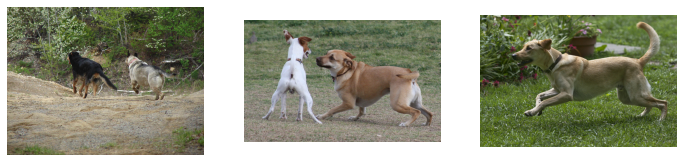

In [79]:
predict_LR(30)

A little dog running on sand .


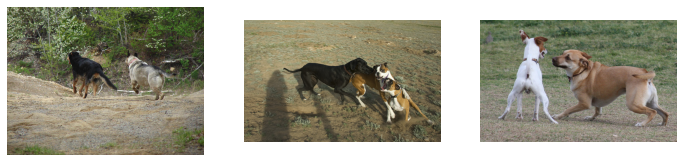

In [80]:
predict_LR(140)

### Вывод

- Случайные выборки из валидационной выборки показывают, что линейная регрессия в целом справляется с работой: она не попадает в детали, но в целом не промахивается совсем уж сильно.

### Нейронная сеть

Обучим сравнительно простую нейросеть:
- Нейросеть не принимает на вход трёхмерные тензоры с элементами типа float64, так что преобразуем входные и выходные вектора в двумерные тензоры float32

In [81]:
X_nn = tf.cast(tf.reshape(X, (X.shape[0], X.shape[2])), dtype=np.float32)
Y_nn = tf.cast(tf.reshape(Y, (Y.shape[0], Y.shape[2])), dtype=np.float32)

Подготовим данные для использования валидации на этапе обучения нейросети:

In [82]:
X_nn_val = tf.stack(X_valid['query_vector'])
Y_nn_val = tf.stack(y_valid['image_vector'])
X_nn_val = tf.cast(tf.reshape(X_nn_val, (X_nn_val.shape[0], X_nn_val.shape[2])), dtype=np.float32)
Y_nn_val = tf.cast(tf.reshape(Y_nn_val, (Y_nn_val.shape[0], Y_nn_val.shape[2])), dtype=np.float32)

In [83]:
def create_nn_model(dout=0.5):
    optimizer = Adam()
    model = Sequential()
    model.add(
        Dense(text_vector_size, activation='relu'))
    if dout > 0:
        model.add(Dropout(dout))
    model.add(Dense(text_vector_size // 2, activation='relu'))
    if dout > 0:
        model.add(Dropout(dout))
    model.add(Dense(text_vector_size // 4, activation='relu'))
    model.add(Dense(image_vector_size, activation='relu'))
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

    return model

In [84]:
nn_model = create_nn_model()

In [85]:
history = nn_model.fit(
    tf.cast(X, dtype=np.float32),
    tf.cast(Y, dtype=np.float32),
    batch_size=100,
    epochs=100,
    validation_data=(X_nn_val, Y_nn_val))

Epoch 1/100
1/5 [=====>........................] - ETA: 3s - loss: 1.0365 - mse: 1.0365

5/5 [==============================] - 1s 50ms/step - loss: 1.0041 - mse: 1.0041 - val_loss: 0.8506 - val_mse: 0.8506
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 0.7873 - mse: 0.7873 - val_loss: 0.6758 - val_mse: 0.6758
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6791 - mse: 0.6791 - val_loss: 0.6685 - val_mse: 0.6685
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 0.6730 - mse: 0.6730 - val_loss: 0.6550 - val_mse: 0.6550
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6535 - mse: 0.6535 - val_loss: 0.6486 - val_mse: 0.6486
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6439 - mse: 0.6439 - val_loss: 0.6421 - val_mse: 0.6421
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6396 - mse: 0.6396 - val_loss: 0.6434 - val_mse: 0.6434
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6369 - mse: 0.6369 - val_los

Видно, что по мере приблежения к 100 эпохе скорость обучения снижается. В итоге, на валидационной выборке значение MSE близкое к линейной регрессии: 0.60

Ищем в заданной серии ivecs lim векторов, наиболее близких к запросу query_vector. Функция возвращает имена файлов

In [86]:
def find_image_NN(query_vector, ivecs, lim=3):
    iv = nn_model.predict(query_vector)
    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

Соберём для удобства предыдущие функции в одну:
- принимает индекс в валидационной выборке
- извлекает из неё запрос, его вектор
- строит прогноз и выводит результат

In [87]:
def predict_NN(idx, df=y_valid):
    qv = X_valid.loc[idx, 'query_vector']
    qt = valid_df[valid_df['annotation_id'] == X_valid.loc[idx, 'annotation_id']]['query_text'].iloc[0]
    images = find_image_NN(qv, df)
    show_images(qt, images)

1/1 [==============================] - 0s 123ms/step
A dog in a grassy field , looking up .


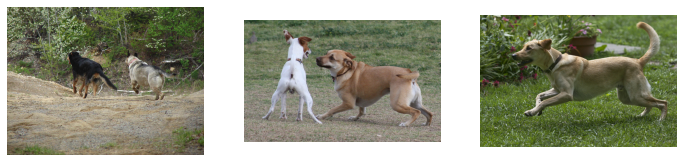

In [88]:
predict_NN(30)

1/1 [==============================] - 0s 15ms/step
A little dog running on sand .


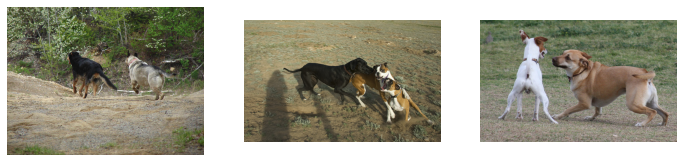

In [89]:
predict_NN(140)

#### Вывод

Судя по выборочным результатам обе модели дают очень близкие прогнозы. Ряд изображений, рекомендованных обеими моделями совпали.

Первое впечатление: предсказательная сила обеих моделей сопоставима, но нейросеть обучается на удивление быстрее регрессии.

## Тестирование модели

Заключительный этап - это тестирование моделей на совершенно новых данных из тестовой выборки. 

Посмотрим, как они себя покажут:

In [90]:
%%time
test_images['image_vector'] = test_images.apply(
    lambda x: tf.cast(model(image_to_array(x['image'], test_path)), dtype=np.float64),axis=1)

CPU times: user 6.57 s, sys: 135 ms, total: 6.71 s
Wall time: 6.74 s


In [91]:
%%time
test_queries['lemm_query'] = test_queries['query_text'].apply(lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]))

CPU times: user 625 ms, sys: 34.1 ms, total: 659 ms
Wall time: 659 ms


In [92]:
%%time
tf_matrix_test = tfvect.transform(test_queries['lemm_query'])
test_queries['query_vector'] = tf_matrix_test.todense().tolist()
test_queries['query_vector'] = test_queries['query_vector'].apply(
    lambda x: tf.reshape(tf.convert_to_tensor(x, dtype=np.float64),(1, text_vector_size)))

CPU times: user 437 ms, sys: 35.7 ms, total: 473 ms
Wall time: 434 ms


In [93]:
test_queries.head()

,query_id,query_text,image,lemm_query,query_vector
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,"Two blonde boy , one in a camouflage shirt and...","((tf.Tensor(0.0, shape=(), dtype=float64), tf...."
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,Two boy be squirt water gun at each other .,"((tf.Tensor(0.0, shape=(), dtype=float64), tf...."
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,Two boy spray each other with water,"((tf.Tensor(0.0, shape=(), dtype=float64), tf...."
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,Two child wear jean squirt water at each other .,"((tf.Tensor(0.0, shape=(), dtype=float64), tf...."
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,Two young boy be squirt water at each other .,"((tf.Tensor(0.0, shape=(), dtype=float64), tf...."


Нам нужны тензоры разного формата для регрессии и нейросети

In [94]:
def lemm(x):
    return " ".join([lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)])

In [95]:
def pred_lr_test(text, ivecs=test_images, lim=3):
    if len(set(text.split()) & set(child_stop)) > 0:
      print ('This image is unavailable in your country in compliance with local laws')
    else:
      lemm_text = lemm(text)
      vector_from_text = tfvect.transform([lemm_text]).todense()
      tf_vect = tf.reshape(tf.convert_to_tensor(vector_from_text,dtype=np.float64),(1, text_vector_size))
      vec = y_pred(vector_from_text)
      df = pd.DataFrame(ivecs)
      for i in df.index:
        df.loc[i, 'dist'] = vec_distance(vec, df.loc[i, 'image_vector'])
      images = df.sort_values(by='dist')['image'].unique()[:lim]
      show_images(text, images, test_path)

In [96]:
pred_lr_test('A boy on cinema')

This image is unavailable in your country in compliance with local laws


A white dog and a black dog in a field


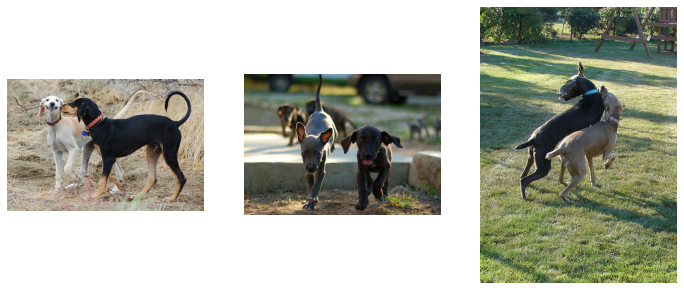

In [97]:
pred_lr_test('A white dog and a black dog in a field')

In [98]:
def pred_nn_test(text, ivecs=test_images, lim=3):
    if len(set(text.split()) & set(child_stop)) > 0:
        print ('This image is unavailable in your country in compliance with local laws')
    else:
        lemm_text = lemm(text)
        vector_from_text = tfvect.transform([lemm_text]).todense()
        tf_vect = tf.reshape(tf.convert_to_tensor(vector_from_text,dtype=np.float64),(1, text_vector_size))
        vec = tf.convert_to_tensor(nn_model.predict(tf_vect), dtype=np.float64)
        df = pd.DataFrame(ivecs)
        for i in df.index:
            df.loc[i, 'dist'] = vec_distance(vec, df.loc[i, 'image_vector'])
            images = df.sort_values(by='dist')['image'].unique()[:lim]
        show_images(text, images, test_path)

1/1 [==============================] - 0s 24ms/step
A white dog and a black dog in a field


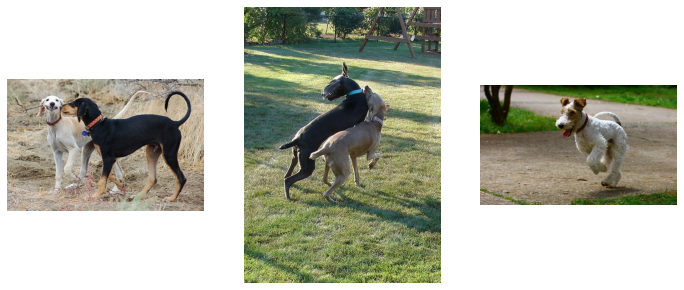

In [99]:
pred_nn_test('A white dog and a black dog in a field')

In [101]:
pred_nn_test('A boy in a field')

This image is unavailable in your country in compliance with local laws


## Выводы

Обе модели показали себя опять очень сходно в смысле прогнозов изображений, их попадания на тестовой выборке достаточно хороши.

В целом, концепция показала свою жизнеспособность, но она нуждается в существенной доработке. 

**Возможные направления**:
- Увеличение датасета может существенно улучшить результаты
- Использование более глубокой нейросети с более тщательным подбором гирперпараметров
- Оценки комьюнити не выглядят очень точными и ценными, но они многочислены. Хорошо бы придумать, как их заставить работать на повышение точности моделей 

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска